In [1]:
import ibis
import pandas as pd

# local
from settings import conf

In [2]:
con_pd = ibis.pandas.connect(**conf['pandas'])
con_psql = ibis.postgres.connect(**conf['postgres'])
con_impala = ibis.impala.connect(**conf['impala'])
con_omniscidb = ibis.omniscidb.connect(**conf['omniscidb'])

In [3]:
con_pd.list_tables()

['functional_alltypes', 'batting', 'awards_players']

In [4]:
con_psql.list_tables()

['array_types',
 'awards_players',
 'batting',
 'diamonds',
 'films',
 'functional_alltypes',
 'geo',
 'geography_columns',
 'geometry_columns',
 'intervals',
 'not_supported_intervals',
 'raster_columns',
 'raster_overviews',
 'spatial_ref_sys',
 'tzone']

In [5]:
con_impala.list_tables()

['alltypes',
 'functional_alltypes',
 'tpch_customer',
 'tpch_lineitem',
 'tpch_nation',
 'tpch_orders',
 'tpch_part',
 'tpch_partsupp',
 'tpch_region',
 'tpch_region_avro',
 'tpch_supplier']

In [6]:
con_omniscidb.list_tables()

['diamonds', 'batting', 'awards_players', 'functional_alltypes', 'geo']

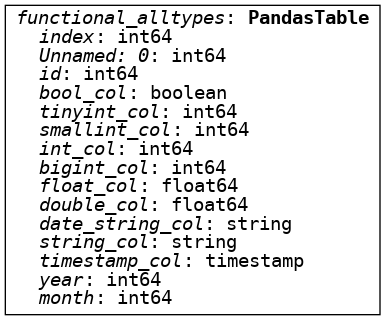

In [7]:
t_pd = con_pd.table('functional_alltypes')
t_pd

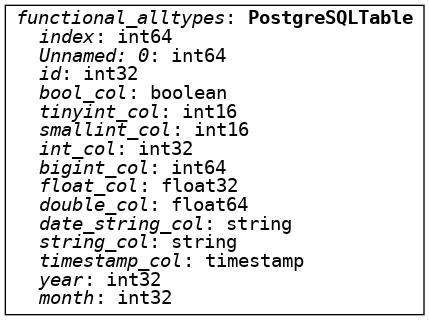

In [8]:
t_psql = con_psql.table('functional_alltypes')
t_psql

### Test 1

In [9]:
def create_expression_group_ntile7(t):
    result_fn = lambda t, win: t.string_col.ntile(buckets=7).over(win)
    
    return t.mutate(
        val=result_fn(
            t,
            win=ibis.window(
                following=0,
                group_by=[t.string_col],
                order_by=[t.id],
            ),
        )
    )
    
expr_pd = create_expression_group_ntile7(t_pd)
expr_psql = create_expression_group_ntile7(t_psql)

In [10]:
def prepare_result(df):
    
    return (
        df.sort_values(['string_col', 'id'])
        .reset_index(drop=True)
    )

df_pd = prepare_result(expr_pd.execute())
df_psql = prepare_result(expr_psql.execute())

In [11]:
df_pd.groupby(['string_col', 'val'])['val'].count()[:7]

string_col  val
0           0      105
            1      105
            2      104
            3      104
            4      104
            5      104
            6      104
Name: val, dtype: int64

In [12]:
df_psql.groupby(['string_col', 'val'])['val'].count()[:7]

string_col  val
0           0      105
            1      105
            2      104
            3      104
            4      104
            5      104
            6      104
Name: val, dtype: int64

In [13]:
df_pd.val.value_counts()

1    1050
0    1050
3    1040
6    1040
2    1040
5    1040
4    1040
Name: val, dtype: int64

In [14]:
df_psql.val.value_counts()

1    1050
0    1050
3    1040
6    1040
2    1040
5    1040
4    1040
Name: val, dtype: int64

In [15]:
cols = ['val', 'id']
assert all(df_psql[cols] == df_pd[cols])

### Test 2

In [16]:
df_salary1 = pd.DataFrame(
    {
        'last_name': [
            'Greenberg',
            'Faviet',
            'Chen',
            'Urman',
            'Sciarra',
            'Popp',
        ],
        'salary': [12000, 9000, 8200, 7800, 7700, 6900],
    }
)
ntile_expected = [0, 0, 1, 1, 2, 3]

In [17]:
con_pd = ibis.pandas.connect({'salary_1': df_salary1})

In [18]:
table_name = 'salary_1'
column = 'salary'
group_by = None
order_by = ['salary']
bucket = 4

t = con_pd.table(table_name)

win = ibis.window(following=0, group_by=None, order_by=order_by)
expr = t.mutate(val=t[column].ntile(buckets=bucket).over(win))
result = expr.execute()
# assert result.val.tolist() == ntile_expected
result

,last_name,salary,val
0,Greenberg,12000,3
1,Faviet,9000,2
2,Chen,8200,1
3,Urman,7800,1
4,Sciarra,7700,0
5,Popp,6900,0


### Test 3

Check the result between OmniSciDB and Impala and PostgreSQL

In [50]:
con = {}
t = {}
expr = {}
result = {}

table_name = 'functional_alltypes'
column = 'string_col'
group_by = ['string_col']
order_by = ['id']
bucket = 4

for b in ['pandas', 'postgres', 'impala', 'omniscidb']:
    con[b] = getattr(ibis, b).connect(**conf[b])
    t[b] = con[b].table(table_name).sort_by(group_by + order_by)
    
    win = ibis.window(following=0, group_by=group_by, order_by=order_by)
    expr[b] = t[b].mutate(val=t[b][column].ntile(buckets=bucket).over(win))
    result[b] = expr[b].execute().sort_values(order_by).reset_index(drop=True)

In [51]:
# pandas x postgresql
pd.testing.assert_series_equal(result['pandas'].val, result['postgres'].val)

In [52]:
# pandas x impala
try:
    pd.testing.assert_series_equal(result['pandas'].val, result['impala'].val)
except AssertionError as e:
    print(e)

Series are different

Series values are different (0.13699 %)
[left]:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]
[right]: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]


In [53]:
# pandas x omniscidb
try:
    pd.testing.assert_series_equal(result['pandas'].val, result['omniscidb'].val)
except AssertionError as e:
    print(e)

Series are different

Series values are different (0.13699 %)
[left]:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]
[right]: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]


In [54]:
# omniscidb x impala
try:
    pd.testing.assert_series_equal(result['omniscidb'].val, result['impala'].val)
except AssertionError as e:
    print(e)

Series are different

Series values are different (0.27397 %)
[left]:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]
[right]: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...]


In [55]:
# summarized pandas result
result['pandas'].groupby('val').string_col.count()

val
0    1830
1    1830
2    1820
3    1820
Name: string_col, dtype: int64

In [56]:
# summarized omniscidb result
result['omniscidb'].groupby('val').string_col.count()

val
0    1830
1    1830
2    1830
3    1810
Name: string_col, dtype: int64

In [57]:
# summarized impala result
result['impala'].groupby('val').string_col.count()

val
0    1830
1    1820
2    1830
3    1820
Name: string_col, dtype: int64

## Conclusions